In [5]:
import warnings
warnings.filterwarnings('ignore')
from pandas import read_csv, Grouper, DataFrame
from matplotlib import pyplot
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import scatter_matrix
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from scipy.stats import boxcox
from matplotlib import pyplot
from math import log
from math import exp

# Datos (serie temporal)

Los datos escogidos, para realizar un análisis de datos longitudinales, son los que recogen la cotización de Bitcoin en dólares (USD), y en la moneda local de Arabia Saudí (SAR), en el mercado saudí. 
Los datos se recogen entre las fechas: 2018-05-11 a 30-01-2021.

Este dataset se encuentra en kaggle ("https://www.kaggle.com/ahmedadam415/digital-currency-time-series").

Como primer paso, leemos el archivo .csv, miramos las primeras filas para comprobar que todo está en orden y dividimos las distintas series temporales que contiene para, más adelante, decantarnos por analizar una de ellas.

In [6]:
series = pd.read_csv('data/dc.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
print(series.head())
series_USD = series.drop(columns=["open_SAR","high_SAR","low_SAR", "close_SAR"])
series_close = pd.DataFrame(series, columns=["close_USD"])
series_volume = pd.DataFrame(series, columns=["volume"])
series_open = pd.DataFrame(series, columns=["open_USD"])

                 open_SAR  open_USD       high_SAR  high_USD        low_SAR  \
2021-01-30  128437.248512  34246.28  131012.723200  34933.00  123106.880000   
2021-01-29  125144.022272  33368.18  144510.037760  38531.90  119695.516160   
2021-01-28  113870.357376  30362.19  126703.438592  33783.98  111919.811840   
2021-01-27  121753.023104  32464.01  122102.860416  32557.29  109668.146688   
2021-01-26  120966.114176  32254.19  123470.218752  32921.88  115652.472448   

             low_USD      close_SAR  close_USD  volume  
2021-01-30  32825.00  128333.212416   34218.54   43072  
2021-01-29  31915.40  128459.450880   34252.20  231827  
2021-01-28  29842.10  125131.570944   33364.86   92621  
2021-01-27  29241.72  113885.208960   30366.15   95911  
2021-01-26  30837.37  121767.124608   32467.77   84972  


El conjunto de datos contiene distintas series temporales: los precios a la apertura del mercado, lo precios al cierre, los valores mínimos y máximos, y el volumen de operaciones. Todos estos tanto en dólares como en SAR.

En el gráfico a continuación podemos verlas representadas gráficamente todas las series del conjunto de datos.

<AxesSubplot:>

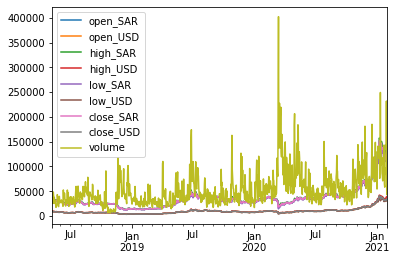

In [7]:
series.plot()

En el siguiente gráfico están representadas las series temporales en distintos gráficos (escogemos solo las series medidas en dólares para evitar un número de gráficas excesivo) se puede observar, como era de esperar, que todas ellas siguen el mismo patrón con la excepción de la serie del volumen de transacciones que parece ser que es más diferente al resto.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

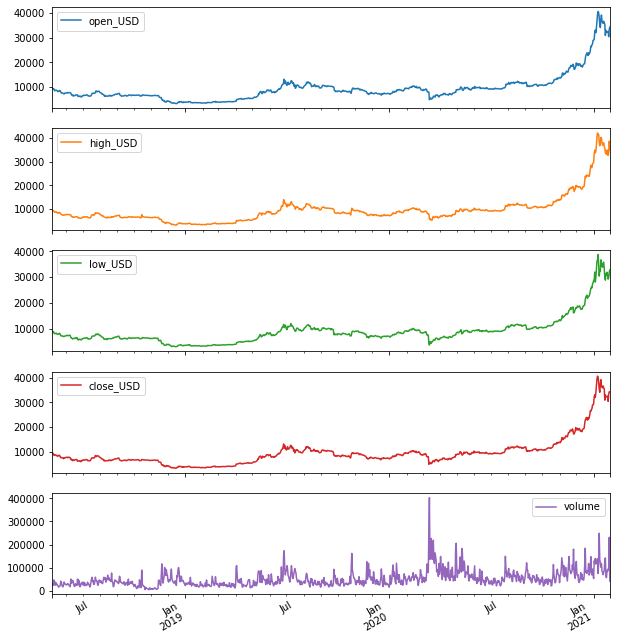

In [8]:
series_USD.plot(subplots=True, figsize=(10, 12))

Como se observa en los dos gráficos siguientes, las correlaciones entre los distintos valores de la serie están muy correlacionaods, como es normal, con excepción del volumen en las operaciones. Este podría utlizarse como variable adicional para modelizar la serie temporal del valor que escojamos predecir.

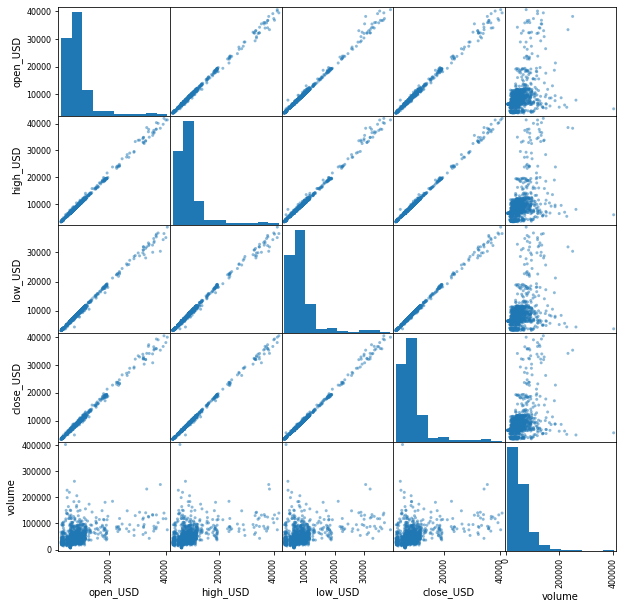

In [9]:
scatter_matrix(series_USD, figsize=(10, 10));

In [10]:
corr = series_USD.corr()
corr.style.background_gradient(cmap='coolwarm')

,open_USD,high_USD,low_USD,close_USD,volume
open_USD,1.000000,0.998266,0.997165,0.996813,0.403964
high_USD,0.998266,1.000000,0.996825,0.998552,0.423805
low_USD,0.997165,0.996825,1.000000,0.998247,0.380777
close_USD,0.996813,0.998552,0.998247,1.000000,0.404061
volume,0.403964,0.423805,0.380777,0.404061,1.000000


En la gráfica de autocorrelación vemos que hay una fuerte correlación hasta 800 días atrás en la serie temporal entre todas las series temporales que componen el conjunto de datos.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

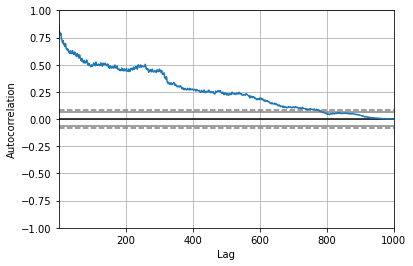

In [11]:
autocorrelation_plot(series_USD)

Sin embargo, si analizamos una serie temporal solamente, en este caso el precio al cierre de mercado, observamos que la correlación entre las observaciones sigue siendo fuerte pero hasta un retardo de 200 días aproximadamente.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

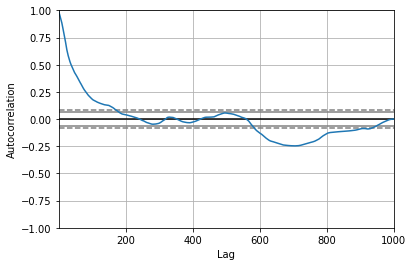

In [12]:
autocorrelation_plot(series_close)

# Análisis de serie temporal univariante

Para realizar el análisis de una serie temporal y modelizarla para predecir sus valores futuros, nos hemos decantado por el precio del Bitcoin al cierre del mercado saudí. 

Empezamos, entonces, realizando el análisis, la descomposición y la extracción de características de esta serie temporal ("series_close") 

Primero, desgranamos la serie por años para ver cómo se comporta esta en los distintos años que contiene el conunto de datos:

    El primer año 2018 la serie se muestra con tendencia decreciente y no muy dispersa.

    En el año 2019 se amplía un poco más la dispersión de los valores, respecto al año anterior, con una tendencia altamente creciente la primera mitad del año para volverse decreciente la segunda mitad.

    El 2020 se muestra menos disperso que el año 2019 pero conmuchas más valores atípicos. Este año la tendencia se muestra claramente creciente.

    El mes de enero de 2021 continúa con la tendencia creciente del año anterior, aunque con una dispersión más destaca que este.

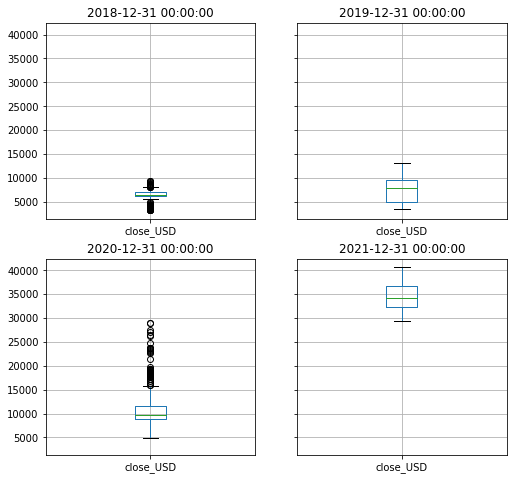

In [13]:
groups = series_close.groupby(Grouper(freq='A'))
groups.boxplot(figsize = (8,8));

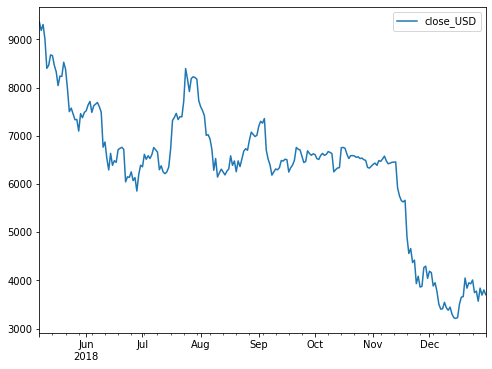

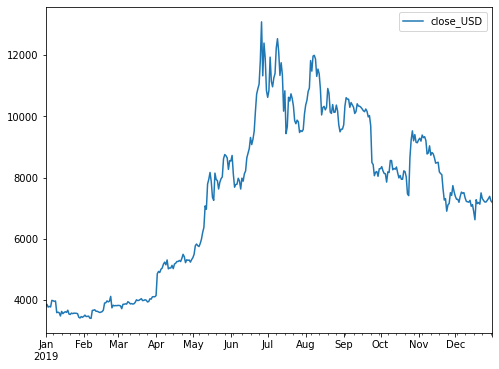

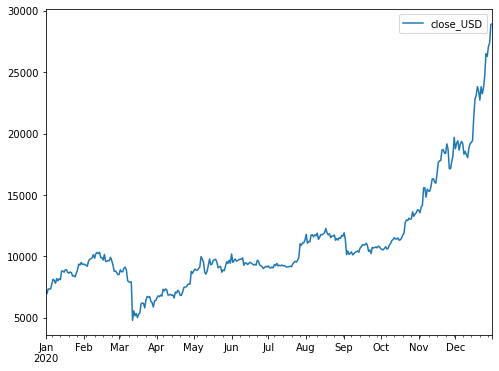

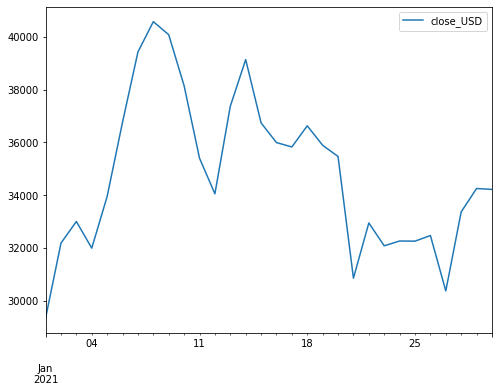

In [14]:
groups.plot(figsize = (8,6));

El gráfico de autocorrelación nos muestra, como anteriormente viimos, una gran correlación entre los valores y sus predecesores. Manteniéndose esta correlación muchos retardos en el tiempo.

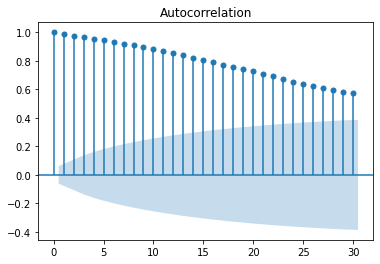

In [15]:
plot_acf(series_close).show(1)

## Descomposicón clásica

A continuación, desomponemos la series medainte dos métodos. La descomposición clásica y la descomposición STL. Con esto intentamos sacar más información sobre la estacionariedad de la serie temporal.

Con la descomposición clásica se asume una componente estacional de año en año. Asunción que la serie temporal no parece asumir, por lo que los gráficos estacionales y de residuos de la descomposición no nos aportan gran información sobre la serie.

<AxesSubplot:>

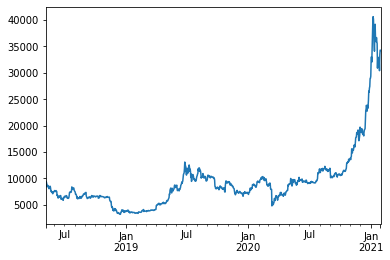

In [16]:
result_cls = seasonal_decompose(series_close, model='additive')
result_cls.observed.plot()

<AxesSubplot:>

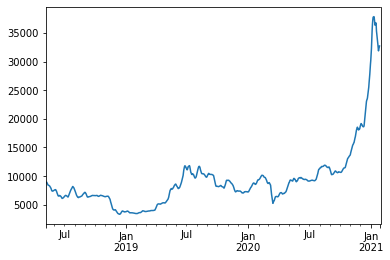

In [17]:
result_cls.trend.plot()

<AxesSubplot:>

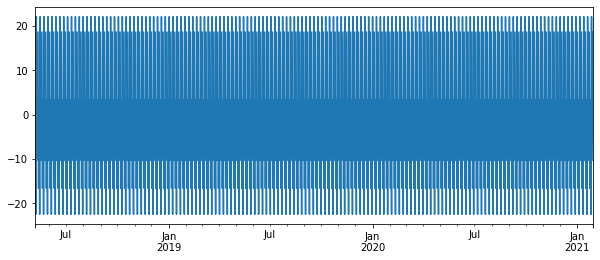

In [18]:
result_cls.seasonal.plot(figsize = (10,4))

<AxesSubplot:>

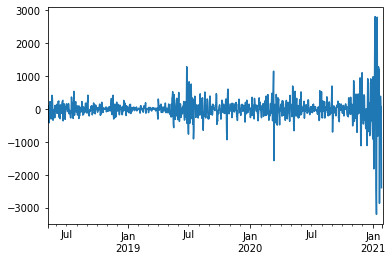

In [19]:
result_cls.resid.plot()

## Descomposción STL

Respecto a la descomposición STL, esta parece acoplarse mejor a la serie temporal pero parece que esta según avanza no se le aprecia una estacionariedad evidente. 
La tendencia parece clara que es a aumentar según avanza la serie, las estacionariedades y los residuos parecen comportarse de manera estable hasta que la serie llega a finales de 2020, principios de 2021, donde parece que cambia completamente de comportamiento.

<AxesSubplot:>

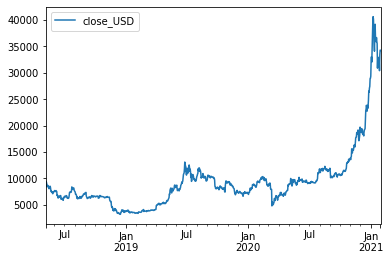

In [20]:
stl = STL(series_close, seasonal=7)
res_STL = stl.fit()
res_STL.observed.plot()

<AxesSubplot:>

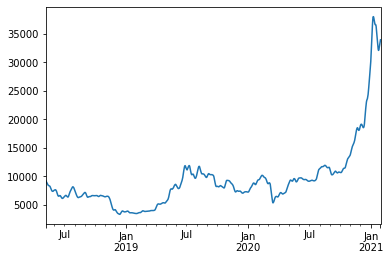

In [21]:
res_STL.trend.plot()

<AxesSubplot:>

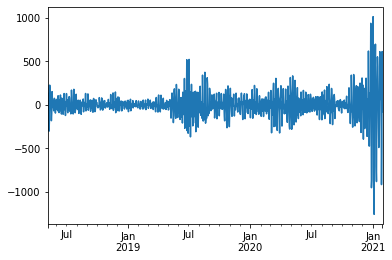

In [22]:
res_STL.seasonal.plot()

<AxesSubplot:>

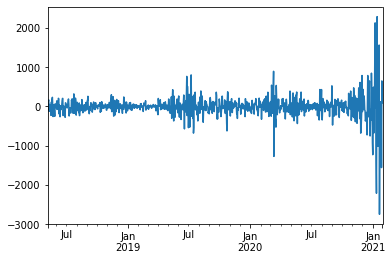

In [23]:
res_STL.resid.plot()

# EXTRACCIÓN DE CARACTERÍSTICAS

Seguidamente extraemos los estadísticos descriptivos de la serie temporal: media, varianza, distribución, etc.

In [24]:
series_close.describe()

,close_USD
count,1000.000000
mean,9310.335850
std,5846.917681
min,3211.720000
25%,6466.762500
50%,8189.330000
75%,10220.170000
max,40582.810000


<AxesSubplot:>

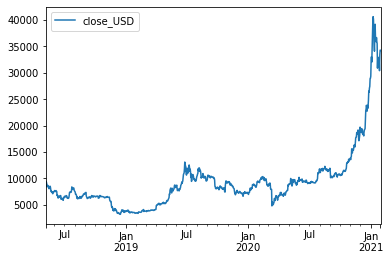

In [25]:
series_close.plot()

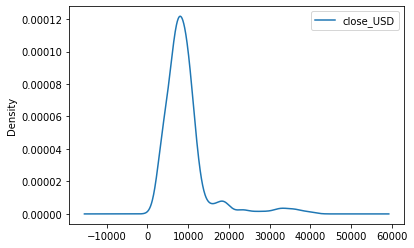

In [26]:
series_close.plot(kind='kde')
pyplot.show()

El gráfico de autorrelaciones muestra que las observaciones de la serie están fuertemente correlacionadas con sus anteriores.

EL gráfico de autocorrelación parcial indica una correlación en el desfase 1, esto nos puede indicar que el ajuste de un modelo de ARIMA de orden 1. Además, surgen correlaciones significativas cada 2, 4, 7 y 2 días (contados desde el útlimo retardo significativo identificado).
No parece observarse un patrón claro pero la serie podría estar correlacionada semanalmente.

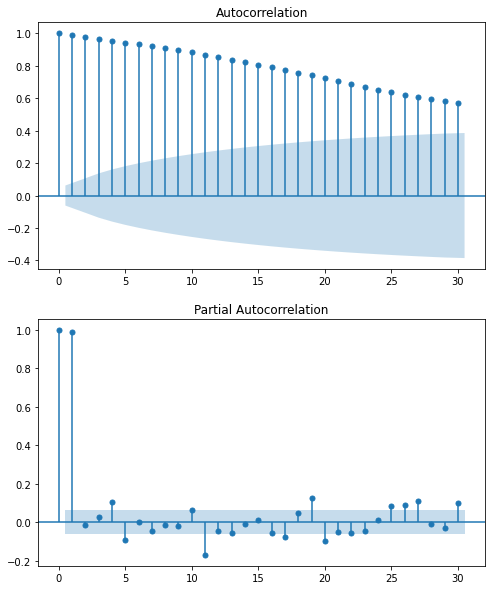

In [27]:
pyplot.figure(figsize =(8,10))
pyplot.subplot(211)
plot_acf(series_close, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series_close, ax=pyplot.gca())
pyplot.show()

# MODELOS

In [33]:
#Dividimos el dataset en train y test
test_close = series_close.iloc[:340]
train_close = series_close.iloc[340:]

## ARIMA

Los modelos ARIMA atiende explícitamente a un conjunto de estructuras estándar de la series temporal para intentar capturar sus aspectos clave, modelizarlos para así describir lo mejor posible la series temporal.
Los modelos ARIMA están compuestos de los modelos:

    -> AR ("Autoregression"), este captura las dependencias de los valores de la series temporal con sus predecesores más   inmediatos.

    -> MA ("Moving average"), este captura el error residual que se produce de una observación a otra respecto a la media   obtenida de las observaciones anteriores.

    -> I ("integrated"), esta diferenciación se obtiene de restar al valor actual de la serie su anterior para poder        convertir la serie en estacionaria.

De cada uno de estos modelos el modelo ARIMA obtiene tres distintos parámetros para tratar de capturar la estructura de la serie temporal:

    -> p: el número de observaciones anteriores que se incluyen en el modelo. 

    -> d: Número de veces que se diferencian las observaciones de la serie. 

    -> q: Tamaño de la ventana de observaciones utlizada para calcular la media de las observaciones y discernir el error   residual. 



### Análisis gráficas autocorrelación

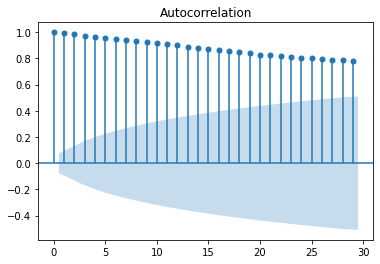

In [34]:
plot_acf(train_close).show(1)

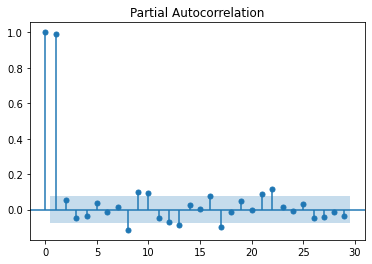

In [35]:
plot_pacf(train_close).show(1)

Las gráficas de autocorrelación y de autocorrelación parcial, nos muestran una serie fuertemente correlada con sus observaciones anteriores sugiriendo un modelo ARIMA (1,0,0).

### Autocorrelación de la serie diferenciada

<AxesSubplot:>

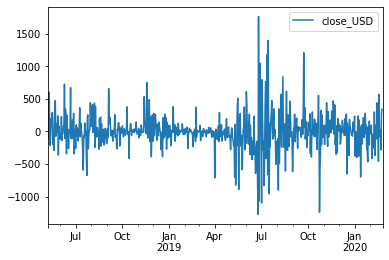

In [36]:
series_close_diff_d = train_close.diff(periods = 1)
series_close_diff_d.plot()

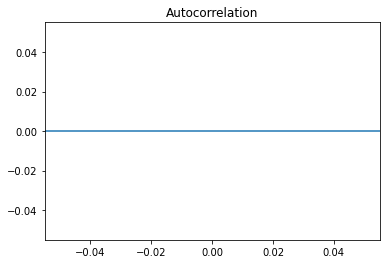

In [37]:
plot_acf(series_close_diff_d).show(1)

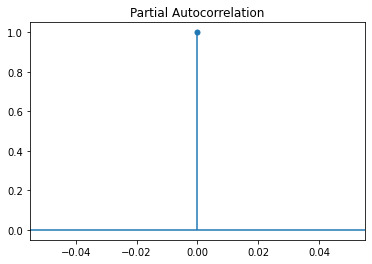

In [38]:
plot_pacf(series_close_diff_d).show(1)

Si diferenciamos la serie en un periodo obtenemos una serie sin ninguna correlación, esto podría sugerir dferenciar la serie en 1 ("integrated") para configurar un modelo ARIMA (1,1,0)

## Construcción modelo ARIMA

De todas formas configuramos un "grid search" para tratar de encontrar los valores que optimicen la métrica del error cuadrático medio (MSE) al predecir un día en adelante en la serie. En el código de acontinuación se definen dos funciones:

    La primera "evaluate_models", escoge los modelos que mejor resultado den respecto al error cuadrático medio probando iterativamente distintas configuraciones de p, d y q.

    La segunda evaluate_arima_model se encarga de entrenar, ajustar el modelo y obtener las predicciones para las distintas configuraciones especificadas anteriormente.

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series_close.values, p_values, d_values, q_values)

Una vez ejecutado el código anterior (interrumpimos la ejecución, ya que, conlleva mucho tiempo de ejecución) obtenemos que la configuración que mejor resultados da es un modelo ARIMA (2,1,2). Tomamos esta configuración como modelo de partida.

In [50]:
días_previsión = 7

In [51]:
X = series_close.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]


model = ARIMA(train, order=(3,1,2))
model_ARIMA = model.fit()
output = model_ARIMA.forecast(steps = días_previsión)

In [52]:
print(model_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  660
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5087.303
Date:                Fri, 16 Jul 2021   AIC                          10186.606
Time:                        16:55:32   BIC                          10213.550
Sample:                             0   HQIC                         10197.051
                                - 660                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7359      0.102     -7.233      0.000      -0.935      -0.536
ar.L2         -0.0122      0.094     -0.131      0.896      -0.196       0.171
ar.L3         -0.1665      0.019     -8.702      0.0

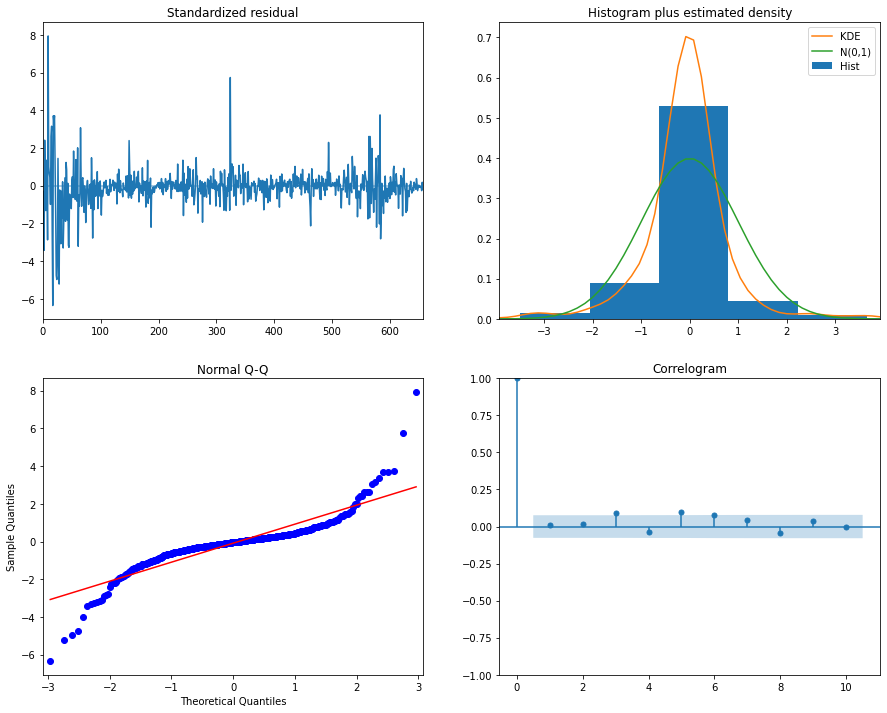

In [53]:
model_ARIMA.plot_diagnostics(figsize=(15,12));

Test RMSE: 137.366


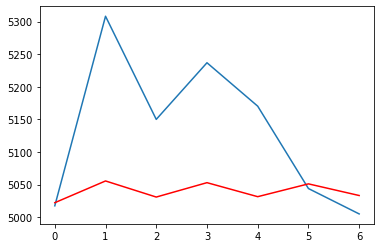

In [54]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test[0:días_previsión], output))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(test[0:días_previsión])
pyplot.plot(output[0:días_previsión], color='red')
pyplot.show()

In [55]:
residuals = [test[i]-output[i] for i in range(len(test[:días_previsión]))]
residuals = DataFrame(residuals)
print(residuals.describe())

                0
count    7.000000
mean    93.511567
std    108.685240
min    -28.231461
25%     -5.980338
50%    119.176369
75%    161.436221
max    252.724299


## SARIMA

El modelo SARIMA es una extensión del modelo ARIMA. Estos son capaces de capturar componentes estacionales en las series, a los parámetros anteriormente descritos para el modelo ARIMA, se añaden estos mismos pero con un retardo estacional, que se tiene que especificar. Estos son:

    -> P: Valores de los que depende la observación actual en la estación previa.

    -> D: Diferenciación de las observaciones actuales respecto de las de la estación previa.

    -> Q: Número de observaciones de la estación previa utlizadas para calcular la media movil.

    -> m: Número de observaciones de la serie temporal que componen una estación.



In [57]:
# Días a preveer:
días_previsión = 7

In [58]:
X = series_close.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# p, d, q:
my_order = (1, 1, 1)

#P, D, Q:
my_seasonal_order = (2, 1, 2, 7)


# Ajuste de modelo
model = sm.tsa.statespace.SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
model_SARIMAX = model.fit()
output = model_SARIMAX.forecast(steps = días_previsión)


In [59]:
print(model_SARIMAX.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  660
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 7)   Log Likelihood               -5117.738
Date:                                Fri, 16 Jul 2021   AIC                          10249.477
Time:                                        16:56:20   BIC                          10280.837
Sample:                                             0   HQIC                         10261.639
                                                - 660                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9969      0.091     10.928      0.000       0.818       1.176
ma.

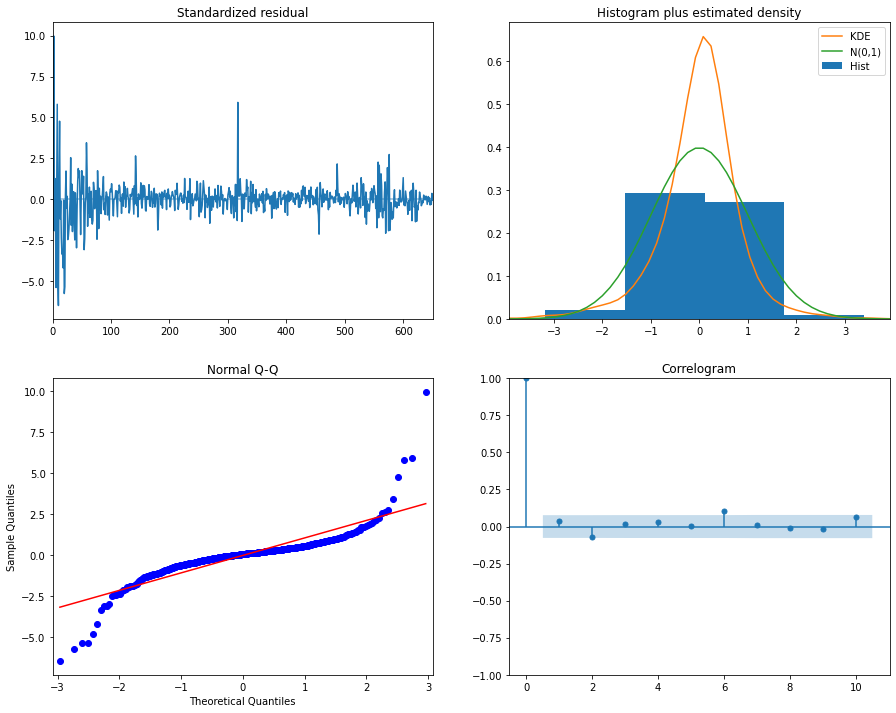

In [60]:
model_SARIMAX.plot_diagnostics(figsize=(15,12));

Test RMSE: 102.404


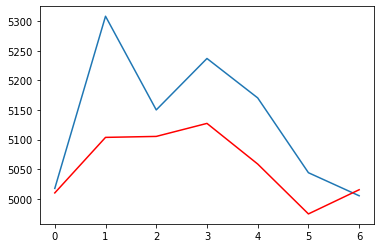

In [61]:
# Evaluación
rmse = sqrt(mean_squared_error(test[0:días_previsión], output))
print('Test RMSE: %.3f' % rmse)

# Visualización previsión del modelo vs valor observado(test)
pyplot.plot(test[0:días_previsión])
pyplot.plot(output[0:días_previsión], color='red')
pyplot.show()

In [62]:
residuals = [test[i]-output[i] for i in range(len(test[:días_previsión]))]
residuals = DataFrame(residuals)
print(residuals.describe())

                0
count    7.000000
mean    76.835931
std     73.120590
min    -10.177819
25%     26.187848
50%     69.603247
75%    110.693963
max    204.662467


## Conclusiones

Al parecer nuestra serie temporal se ajusta mejor a un modelo SARIMA(1,1,1)(2,1,2)7. Esto puede explicarse ya que en la gráfica de autocorrelaciones parciales se observaba que cada 4 y 7 días, aproximadamente, existía una cierta correlación entre las observaciones. Esto puede suponer un compotamiento estacional de índole semanal.

De este modo, el modelo SARIMA con estacionalidad de 7 periodos (días) para modelizar mejor la serie temporal, que el modelo ARIMA (3,1,2) que modeliza la serie teniendo en cuenta las 3 observaciones pasadas, diferencia 1 vez la serie y tiene en cuenta 2 observaciones pasadas para discernir el error o ruido blanco. Parámetros parecidos se modelan en el modelo SARIMA pero con un retardo de 7 días.

El RMSE en la previsón a 7 días en el modelo SARIMA es de 102.404

El RMSE en la previsón a 7 días en el modelo ARIMA es de 137.366

En ambos modelos los residuos parecen no tienen media 0 pero se ha ajustado para que sean lo más cercanas posibles: 
       
      En ARIMA los residuos tienen media 93.511567, no hya correlaciones entre ellos y siguen una distribución parecida a             la normal.
       
      En SARIMA los residuos tienen media 76.835931, no hay correlaciones entre estos y la distribución no es tan parecida a         la normal como en ARIMA.